# Test of SciNet with a force pendulum

### Creation of synthetic data for force pendulum + damping + little angles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

import gc

from physical_parameters_SciNet.model_instances.n1_setting_synthetic_forced_damped_pendulum import config



Choosen device = cuda


#### One damped forced pendulum with a constant forcing

In [2]:
def create_synthetic_damped_forced_pendulum(A: float, omega: float, beta: float, kapa: float, theta0: float, omega0: float, t: np.ndarray) -> np.ndarray:
    """
    Create synthetic data for a damped forced pendulum with small angle approximation.

    Parameters:
    A (float): Amplitude of the forcing term.
    omega (float): Frequency of the forcing term.
    beta (float): Damping coefficient. Corresponds to 'b/L' in the equation.
    kapa (float): Spring constant of the pendulum. Corresponds to 'g/L' in the equation.
    theta0 (float): Initial angle (in radians).
    omega0 (float): Initial angular velocity (in radians per second).
    t (numpy array): Time array.

    Returns:
    numpy array: Array of angles at each time step.
    """

    def pendulum_ode(t, y):
        theta, omega_t = y
        dtheta_dt = omega_t
        domega_dt = - beta * omega_t - kapa * theta + A * np.cos(omega * t)
        return [dtheta_dt, domega_dt]

    y0 = [theta0, omega0]
    sol = solve_ivp(pendulum_ode, [t[0], t[-1]], y0, t_eval=t)
    
    return sol.y[0]  # Return only the angle array

In [3]:
A = 1.0
omega = 3.0
beta = 0.2
kapa = 3.0
theta0 = 0.9  # Initial angle in radians
omega0 = 0.0  # Initial angular velocity
t = np.linspace(0, 100, 10000)  # Time from 0 to 10 seconds

y = create_synthetic_damped_forced_pendulum(A, omega, beta, kapa, theta0, omega0, t)

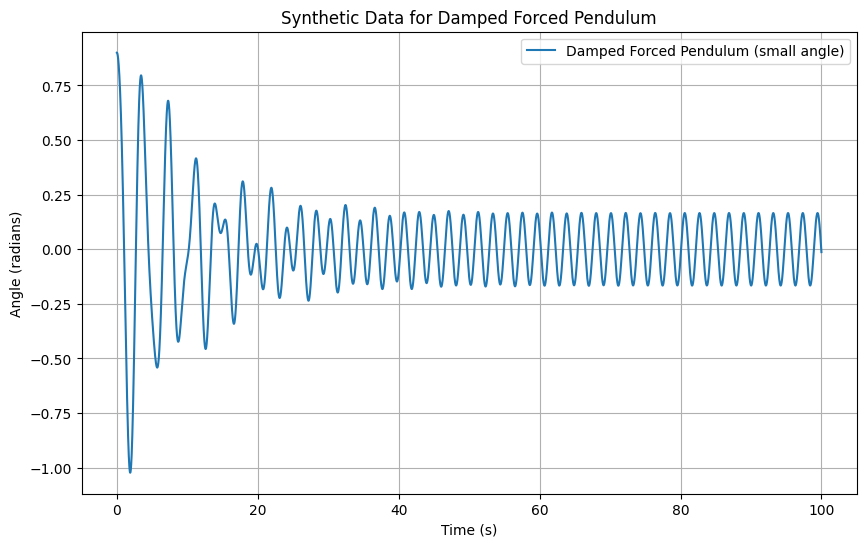

In [4]:
fig = plt.figure(figsize=(10, 6))
plt.plot(t, y, label='Damped Forced Pendulum (small angle)')
plt.title('Synthetic Data for Damped Forced Pendulum')
plt.xlabel('Time (s)')
plt.ylabel('Angle (radians)')
plt.legend()
plt.grid()
plt.show()

#### Create complexe profil of forcing

-> trapezoidale shape

In [5]:
def create_trapezoidal_forcing(t: np.ndarray, start_value: float, end_value: float, proportions: list[float], N_time_steps: int) -> np.ndarray:
    """
    Create a trapezoidal forcing function.

    Args:
        t (numpy array): Time array.
        start_value (float): Initial value of the forcing.
        end_value (float): Value at the plateau of the trapezoid.
        proportions (list): List of 4 proportions [p1, p2, p3, p4] defining:
                        - from 0 to p1: constant value at start_value
                        - from p1 to p2: linear rise from start_value to end_value
                        - from p2 to p3: plateau at end_value
                        - from p3 to p4: linear fall from end_value to start_value
                        - from p4 to 1: constant value at start_value
        N_time_steps (int): Number of time steps. Theoretically len(t).

    Returns:
        array: Array of the trapezoidal forcing function.
    """
    assert len(t) == N_time_steps, "Length of time array must match N_time_steps"
    if len(proportions) != 4:
        raise ValueError("proportions must be a list of 4 values")

    p1, p2, p3, p4 = proportions
    if not (0 <= p1 <= p2 <= p3 <= p4 <= 1):
        raise ValueError("Proportions must be increasing and between 0 and 1")

    # Transition indices
    idx1 = int(p1 * N_time_steps)
    idx2 = int(p2 * N_time_steps)
    idx3 = int(p3 * N_time_steps)
    idx4 = int(p4 * N_time_steps)

    # Initialize the array
    omega_array = np.ones(N_time_steps) * start_value

    # Phase 1: Linear rise (p1 to p2)
    if idx2 > idx1:
        slope_up = (end_value - start_value) / (t[idx2] - t[idx1])
        omega_array[idx1:idx2] = start_value + slope_up * (t[idx1:idx2] - t[idx1])

    # Phase 2: Plateau (p2 to p3)
    omega_array[idx2:idx3] = end_value

    # Phase 3: Linear fall (p3 to p4)
    if idx4 > idx3:
        slope_down = (start_value - end_value) / (t[idx4] - t[idx3])
        omega_array[idx3:idx4] = end_value + slope_down * (t[idx3:idx4] - t[idx3])
    
    return omega_array

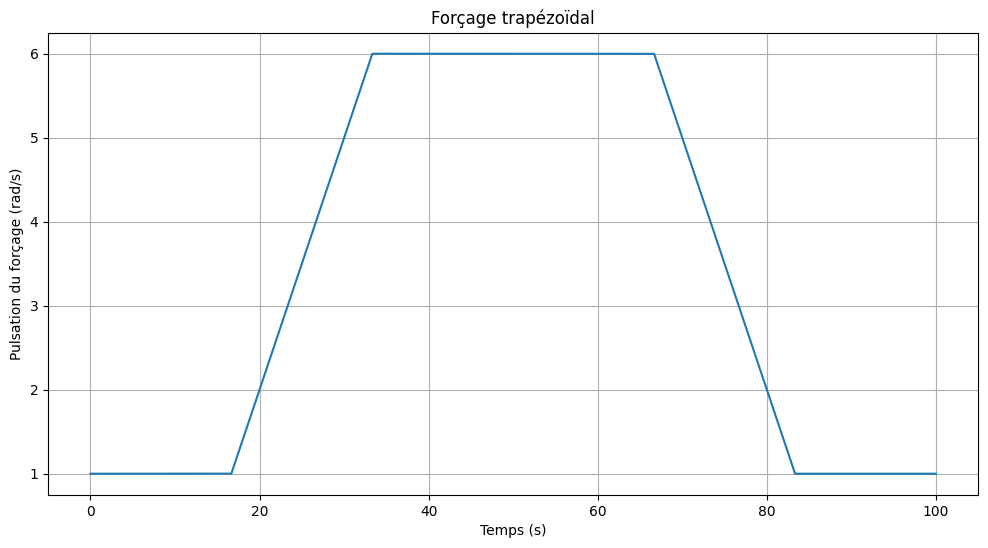

In [6]:
N_time_steps = 100000
t = np.linspace(0, 100, N_time_steps)

omega_array = create_trapezoidal_forcing(
    t=t,
    start_value=1.0,
    end_value=6.0,
    proportions=[1/6, 1/3, 2/3, 5/6],
    N_time_steps=N_time_steps
)

plt.figure(figsize=(12, 6))
plt.plot(t, omega_array)
plt.xlabel('Temps (s)')
plt.ylabel('Pulsation du forçage (rad/s)')
plt.title('Forçage trapézoïdal')
plt.grid(True)
plt.show()

#### Create pendulum with trapezoidal forcing

In [7]:
def create_synthetic_damped_forced_pendulum(A_array: np.ndarray, omega_array: np.ndarray, beta: float, kapa: float, theta0: float, omega0: float, t: np.ndarray) -> np.ndarray:
    """
    Create synthetic data for a damped forced pendulum with small angle approximation
    and time-varying forcing frequency.

    Args:
        A (numpy array): Amplitude of the forcing term (time-varying).
        omega_array (numpy array): Array of forcing frequencies at each time step.
        beta (float): Damping coefficient. Corresponds to 'b/L' in the equation.
        kapa (float): Spring constant of the pendulum. Corresponds to 'g/L' in the equation.
        theta0 (float): Initial angle (in radians).
        omega0 (float): Initial angular velocity (in radians per second).
        t (numpy array): Time array.

    Returns:
        numpy array: Array of angles at each time step.
    """
    # Check if omega_array has the same length as t
    if len(omega_array) != len(t):
        raise ValueError("omega_array must have the same length as t")
    # Check if A is constant or variable
    if len(A_array) != len(t):
        raise ValueError("If A is an array, it must have the same length as t")


    def pendulum_ode(t, y):
        # Find the index of the current time step
        idx = np.abs(t_array - t).argmin()
        
        theta, omega_t = y
        dtheta_dt = omega_t
        # Use the forcing value corresponding to the current time
        domega_dt = - beta * omega_t - kapa * theta + A_array[idx] * np.cos(omega_array[idx] * t)
        return [dtheta_dt, domega_dt]

    # Store the global time array for use in the ODE
    global t_array
    t_array = t.copy()
    
    y0 = [theta0, omega0]
    sol = solve_ivp(pendulum_ode, [t[0], t[-1]], y0, t_eval=t, method='RK45')
    
    return sol.y[0]  # Return only the angle array

In [8]:
# Time array
N_time_steps = 1000
t = np.linspace(0, 100, N_time_steps)

# Variable pulsation (trapezoidal shape)
A_array = create_trapezoidal_forcing(
    t=t,
    start_value=1.0,
    end_value=10.0,
    proportions=[1/6, 1/3, 2/3, 5/6],
    N_time_steps=N_time_steps
)
# Variables amplitudes or not
omega_value = 1.0
omega_array = np.ones(N_time_steps) * omega_value
# Parameters
beta = 0.1
kapa = 0.5
theta0 = 1.0
omega0 = 0.0

y = create_synthetic_damped_forced_pendulum(A_array, omega_array, beta, kapa, theta0, omega0, t)

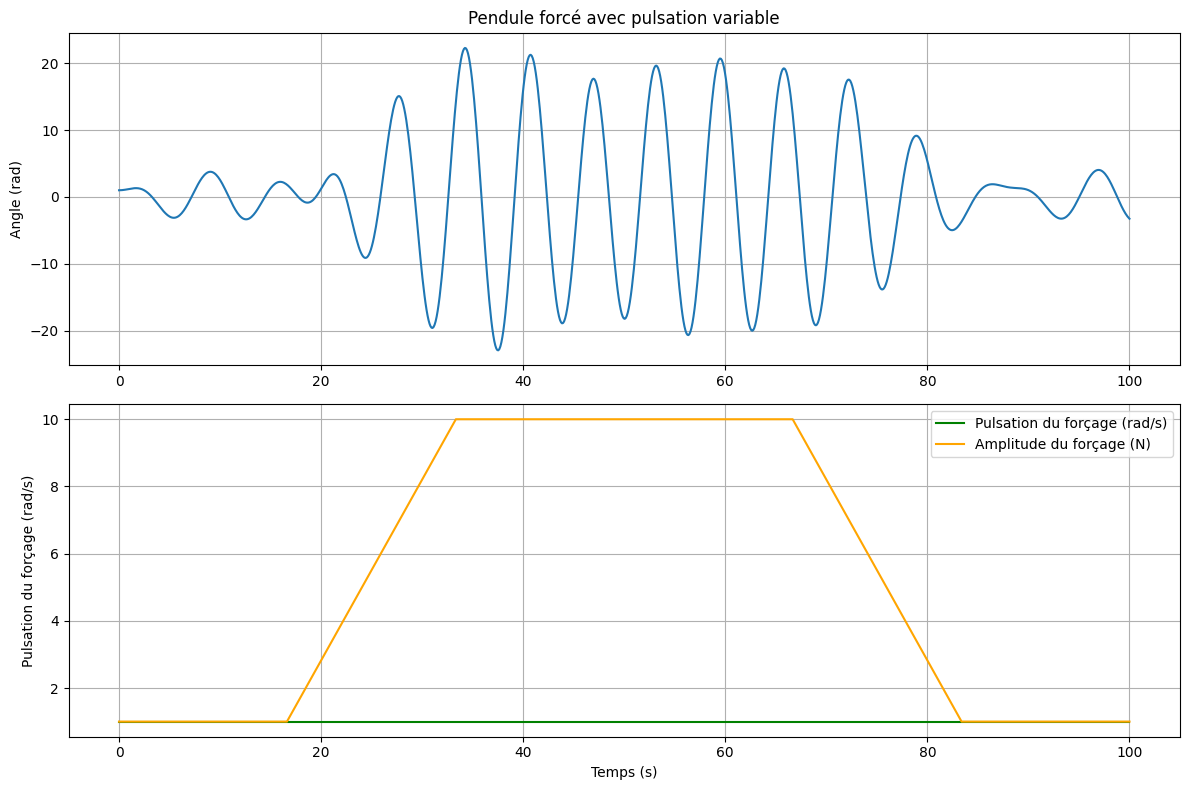

In [9]:
# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(t, y)
ax1.set_ylabel('Angle (rad)')
ax1.set_title('Pendule forcé avec pulsation variable')
ax1.grid(True)

ax2.plot(t, omega_array, color='green', label='Pulsation du forçage (rad/s)')
ax2.plot(t, A_array, color='orange', label='Amplitude du forçage (N)')
ax2.set_ylabel('Pulsation du forçage (rad/s)')
ax2.set_xlabel('Temps (s)')
ax2.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### Create Dataset of various parameters for differents forcing

* A: fixed
* theta0: fixed
* omega0: fixed
* kapa: varying randomly
* beta: varying randomly
* omega_forcing: choosen among a discret number


In [10]:
def create_dataset(
        N_sample: int, 
        maxtime: float, 
        n_timestep: int, 
        kapa_range: tuple, 
        beta_range: tuple, 
        trapezoidal_forcing_values: dict,
        A_value: float | None = 1.0,
        omega_value: float | None = 1.0,
        theta0: float = 0.5, 
        omega0: float = 0.0
    ):
    """
    Create a dataset of synthetic damped forced pendulum data with varying parameters.

    Args:
        N_sample (int): Number of samples to generate.
        maxtime (float): Maximum time for the simulation.
        n_timestep (int): Number of time steps in the simulation.
        kapa_range (tuple): Tuple defining the range of spring constants (min, max).
        beta_range (tuple): Tuple defining the range of damping coefficients (min, max).
        trapezoidal_forcing_values (dict): dictionary of args for the forcing parameters.
        A_value (float or None): Amplitude of the forcing term (constant or variable).
        omega_forcing_values (float or None): Pulsation of the forcing term (constant or variable).

    Parameters:
        theta0 (float): Initial angle (in radians).
        omega0 (float): Initial angular velocity (in radians per second).

    Returns:
        list: List of dictionaries containing parameters and corresponding angle arrays.
    """
    assert (A_value is not None) ^ (omega_value is not None), "Either A_value or omega_value must be provided as constant."

    dataset = []
    t = np.linspace(0, maxtime, n_timestep)

    for _ in tqdm(range(N_sample)):
        # Choose forcing frequency parameters
        trap_start, trap_end = 1.0, 0.0
        while trap_start >= trap_end:
            trap_start = np.random.uniform(*trapezoidal_forcing_values["start_value"])
            trap_end = np.random.uniform(*trapezoidal_forcing_values["end_value"])
        proportions = [np.random.uniform(*trapezoidal_forcing_values["proportions"][a]) for a in range(4)]
        trap_forcing_values_sampled = {
            "start_value": trap_start,
            "end_value": trap_end,
            "proportions": proportions
        }
        # Randomly choose a forcing frequency from the provided values
        if omega_value is not None:
            A_forcing = create_trapezoidal_forcing(t=t, N_time_steps=n_timestep, **trap_forcing_values_sampled)
            omega_forcing = np.ones(n_timestep) * omega_value
        else:
            omega_forcing = create_trapezoidal_forcing(t=t, N_time_steps=n_timestep, **trap_forcing_values_sampled)
            A_forcing = np.ones(n_timestep) * A_value

        # Randomly sample kapa and beta within their respective ranges
        kapa = np.random.uniform(*kapa_range)
        beta = np.random.uniform(*beta_range)

        # Create the synthetic data
        y = create_synthetic_damped_forced_pendulum(A_forcing, omega_forcing, beta, kapa, theta0, omega0, t)

        # Store the parameters and the resulting angle array
        sample = {
            'kapa': kapa,
            'beta': beta,
            'forcing': omega_forcing if omega_value is None else A_forcing,
            'time': t,
            'angle': y
        }
        
        dataset.append(sample)
    
    return dataset

In [11]:
eps = 1/13
trapezoid_range = [(1/6-eps, 1/6+eps), (1/3-eps, 1/3+eps), (2/3-eps, 2/3+eps), (5/6-eps, 5/6+eps)]
trapezoidal_forcing_ranges = {
    "start_value": (0.5, 2.0),
    "end_value": (1.0, 6.0),
    "proportions": trapezoid_range,
}

beta_range = config.BETA_RANGE
kapa_range = config.KAPA_RANGE
N_samples = config.N_SAMPLES
N_time_steps = config.TIMESTEPS
max_time = config.MAXTIME

dataset = create_dataset(
    N_sample=N_samples,
    maxtime=max_time,
    n_timestep=N_time_steps,
    kapa_range=kapa_range,
    beta_range=beta_range,
    trapezoidal_forcing_values=trapezoidal_forcing_ranges,
    A_value=config.A_VALUE,
    omega_value=config.OMEGA_VALUE,
    theta0=config.THETA0,
    omega0=config.OMEGA0
)

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [12:42<00:00, 26.23it/s]


In [14]:
len(dataset)

20000

In [12]:
path = config.DIR_RAW_DATA / "synthetic_damped_forced_pendulum_dataset.npy"

#np.save(path, dataset)
dataset = np.load(path, allow_pickle=True)

In [13]:
dataset[0]

{'kapa': 1.6326304372798894,
 'beta': 4.3977926559872085,
 'forcing': array([1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.22359505, 1.38537993, 1.5471648 , 1.70894968,
        1.87073455, 2.03251942, 2.1943043 , 2.35608917, 2.51787405,
        2.67965892, 2.8414438 , 3.00322867, 3.16501354, 3.32679842,
        3.48858329, 3.65036817, 3.81215304, 3.97393792, 4.13572279,
        4.29750766, 4.45929254, 4.62107741, 4.78286229, 4.94464716,
        5.10643203, 5.26821691, 5.43000178, 5.5

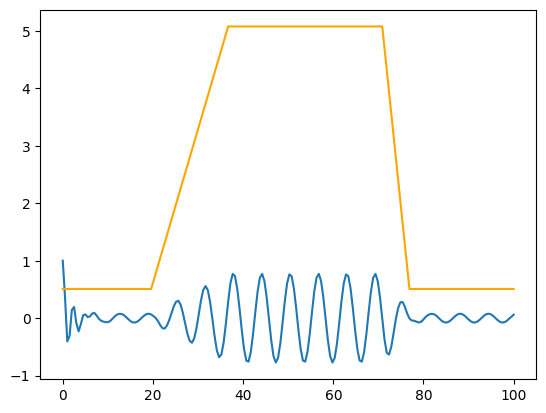

In [14]:
id_to_plot = 9
plt.plot(dataset[id_to_plot]['time'], dataset[id_to_plot]['angle'])
plt.plot(dataset[id_to_plot]['time'], dataset[id_to_plot]['forcing'], color='orange')
plt.show()

#### Create dataloader for SciNet

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

In [16]:
class forced_pendulum_dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        observations = torch.tensor(sample['angle'], dtype=torch.float32)
        questions = torch.tensor(sample['forcing'], dtype=torch.float32)
        params = torch.tensor([sample['kapa'], sample['beta']], dtype=torch.float32)
        return observations, questions, params

In [17]:
split_ratio = config.SPLIT_RATIO  # Train, Validation, Test

train_size = int(split_ratio[0] * len(dataset))
val_size = int(split_ratio[1] * len(dataset))
test_size = len(dataset) - train_size - val_size

Dataset_custom = forced_pendulum_dataset(dataset)

train_dataset, val_dataset, test_dataset = random_split(Dataset_custom, [train_size, val_size, test_size])

In [18]:
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")
print("Types of datasets:", type(train_dataset), type(val_dataset), type(test_dataset))

Train size: 14000
Validation size: 3000
Test size: 3000
Types of datasets: <class 'torch.utils.data.dataset.Subset'> <class 'torch.utils.data.dataset.Subset'> <class 'torch.utils.data.dataset.Subset'>


In [19]:
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE_TRAIN, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE_EVAL, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE_EVAL, shuffle=True)

#### Scinet network

In [20]:
class SciNetEncoder(nn.Module):
    def __init__(self, 
                 input_size: int = 1000, 
                 latent_size: int = 3, 
                 hidden_sizes: list[int] = [128, 64]
                 ) -> None:
        super().__init__()
        self.input_sizes = [input_size] + hidden_sizes[:-1]
        self.output_sizes = hidden_sizes
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))]
        )
        self.mean_layer = nn.Linear(hidden_sizes[-1], latent_size)
        self.logvar_layer = nn.Linear(hidden_sizes[-1], latent_size)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor]:
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar
    

class QuestionDecoder(nn.Module):
    def __init__(self, 
                 latent_size: int = 3, 
                 question_size: int = 1000, 
                 output_size: int = 1000, 
                 hidden_sizes: list = [128, 128]
                 ) -> None:
        super().__init__()
        self.input_sizes = [latent_size + question_size] + hidden_sizes
        self.output_sizes = hidden_sizes + [output_size]
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))] + [nn.Identity()]
        )

    def forward(self, z: torch.Tensor, question: torch.Tensor) -> torch.Tensor:
        z = torch.cat([z, question], dim=-1)
        for layer, activation in zip(self.layers, self.activations):
            z = activation(layer(z))
        return z


class PendulumNet(nn.Module):
    def __init__(self, 
                 input_size: int = 1000, 
                 enc_hidden_sizes: list[int] = [128, 64], 
                 latent_size: int = 3, 
                 question_size: int = 1000,
                 dec_hidden_sizes: list[int] = [128, 128], 
                 output_size: int = 1000
                 ) -> None:
        super().__init__()
        self.encoder = SciNetEncoder(input_size=input_size, latent_size=latent_size, hidden_sizes=enc_hidden_sizes)
        self.decoder = QuestionDecoder(latent_size=latent_size, question_size=question_size, output_size=output_size, hidden_sizes=dec_hidden_sizes)


    def forward(self, x, question):
        mean, logvar = self.encoder(x)
        z = self.reparametrize(mean, logvar)
        possible_answer = self.decoder(z, question)
        return possible_answer, mean, logvar

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std


In [21]:
def scinet_loss_forced_pendulum(
        possible_answer: torch.Tensor, 
        a_corr: torch.Tensor, 
        mean: torch.Tensor, 
        logvar: torch.Tensor, 
        beta: float = 0.003
        ) -> torch.Tensor:

    recon_loss = torch.nn.MSELoss()(possible_answer.squeeze(), a_corr.squeeze())
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).mean()
    return recon_loss + beta * kld_loss, kld_loss, recon_loss

#### Train scinet

In [22]:
from physical_parameters_SciNet.ml_tools.train_callbacks import EarlyStopping, GradientClipping, LRScheduling

In [23]:
def train_scinet(
        train_loader: DataLoader, 
        valid_loader: DataLoader,
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer, 
        num_epochs: int = 150, 
        kld_beta: float = 0.001, 
        early_stopper: EarlyStopping = None, 
        gradient_clipper: GradientClipping = None, 
        lr_scheduler: LRScheduling = None,
        device: torch.device = torch.device('cpu')
        ) -> None:

    torch.cuda.empty_cache()
    model.to(device)
    print("------training on {}-------\n".format(device))
    history = {'train_loss': [], 'valid_loss': []}
    print(f"{'Epoch':<20} ||| {'Train Loss':<15} ||| {'KLD Loss':<12} {'Recon Loss':<12} ||||||| {'Valid Loss':<15}")

    # Training
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        kld_loss, recon_loss = 0.0, 0.0
        for observations, questions, _ in tqdm(train_loader, desc="Training", leave=False):
            a_corr = observations.clone()
            observations = observations.to(device)
            questions = questions.to(device)
            a_corr = a_corr.to(device)

            optimizer.zero_grad()
            possible_answer, mean, logvar = model(observations, questions)
            loss, l_kld, l_recon = scinet_loss_forced_pendulum(possible_answer, a_corr, mean, logvar, beta=kld_beta)
            loss.backward()
            if gradient_clipper is not None:
                gradient_clipper.on_backward_end(model)
            optimizer.step()

            train_loss += loss.item() * observations.size(0)
            kld_loss += l_kld.item() * observations.size(0)
            recon_loss += l_recon.item() * observations.size(0)
        train_loss /= len(train_loader.dataset)
        kld_loss /= len(train_loader.dataset)
        recon_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Evaluation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for observations, questions, _ in tqdm(valid_loader, desc="Validation", leave=False):
                a_corr = observations.clone()
                observations = observations.to(device)
                questions = questions.to(device)
                a_corr = a_corr.to(device)

                possible_answer, mean, logvar = model(observations, questions)
                loss = scinet_loss_forced_pendulum(possible_answer, a_corr, mean, logvar, beta=kld_beta)[0]
                valid_loss += loss.item() * observations.size(0)
        
        valid_loss /= len(valid_loader.dataset)
        history['valid_loss'].append(valid_loss)

        print(f"{f'{epoch+1}/{num_epochs}':<20}  |  {train_loss:<15.6f}  |  {kld_loss:<12.6f} {recon_loss:<12.6f}    |    {valid_loss:<15.6f}")

        if early_stopper is not None:
            if early_stopper.check_stop(valid_loss, model):
                print(f"Early stopping at epoch {epoch + 1} with loss {valid_loss:.4f}")
                print(f"Restoring best weights for model.")
                early_stopper.restore_best_weights(model)
                break

        if lr_scheduler is not None:
            lr_scheduler.step(valid_loss)

        path = config.DIR_PARAMS_CHECKPOINTS / "pendulum_scinet_checkpointed.pth"
        torch.save(model.state_dict(), path)

        del observations, questions, a_corr, possible_answer, mean, logvar, loss, l_kld, l_recon
        torch.cuda.empty_cache()
        gc.collect()
    
    return history

In [24]:
def plot_history(history_train: list, history_valid: list) -> None:
    plt.figure(figsize=(8, 5))
    plt.plot(history_train, 'b-', linewidth=2, label='Train Loss')
    plt.plot(history_valid, 'r-', linewidth=2, label='Valid Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    path = config.DIR_FIGURES / "training_validation_loss.png"
    plt.savefig(path)
    return None

In [25]:
device = torch.device("cuda:1")
device

device(type='cuda', index=1)

In [26]:
### SCINET architecture
TIMESTEPS = config.TIMESTEPS  # 200
M_INPUT_SIZE = TIMESTEPS
M_ENC_HIDDEN_SIZES = config.M_ENC_HIDDEN_SIZES  # [500, 100] # [500, 100, 100]
M_LATENT_SIZE = config.M_LATENT_SIZE  # 3
M_QUESTION_SIZE = TIMESTEPS
M_DEC_HIDDEN_SIZES = config.M_DEC_HIDDEN_SIZES  # [500, 500] # [200, 200, 300]
M_OUTPUT_SIZE = TIMESTEPS

### Hyperparameters
BATCH_SIZE_TRAIN = config.BATCH_SIZE_TRAIN  # 50
BATCH_SIZE_VALID = config.BATCH_SIZE_EVAL  # 50
FIRST_LEARNING_RATE = config.FIRST_LEARNING_RATE  # 5e-4
WEIGHT_DECAY = config.WEIGHT_DECAY  # 1e-6
KLD_BETA = config.KLD_BETA  # 0.0003

### Train parameters
NUM_EPOCHS = config.NUM_EPOCHS  # 150
ES_PATIENCE = config.ES_PATIENCE  # 12
ES_MIN_DELTA = config.ES_MIN_DELTA  # 5e-4
GC_MAX_NORM = config.GC_MAX_NORM  # 1.0
LRS_FACTOR = config.LRS_FACTOR  # 0.66
LRS_PATIENCE = config.LRS_PATIENCE  # 5
LRS_MIN_LR = config.LRS_MIN_LR  # 1e-7
LRS_MIN_DELTA = config.LRS_MIN_DELTA  # 1e-4

In [27]:
pendulum_net = PendulumNet(
    input_size=M_INPUT_SIZE,
    enc_hidden_sizes=M_ENC_HIDDEN_SIZES,
    latent_size=M_LATENT_SIZE,
    question_size=M_QUESTION_SIZE,
    dec_hidden_sizes=M_DEC_HIDDEN_SIZES,
    output_size=M_OUTPUT_SIZE
)
optimizer = torch.optim.Adam(pendulum_net.parameters(), lr=FIRST_LEARNING_RATE, weight_decay=WEIGHT_DECAY)
early_stopper = EarlyStopping(patience=ES_PATIENCE, min_delta=ES_MIN_DELTA)
gradient_clipper = GradientClipping(max_norm=GC_MAX_NORM)
lr_scheduler = LRScheduling(optimizer, factor=LRS_FACTOR, patience=LRS_PATIENCE, min_lr=LRS_MIN_LR, min_delta=LRS_MIN_DELTA)

In [28]:
history = train_scinet(
    train_loader, 
    valid_loader, 
    pendulum_net, 
    optimizer, 
    num_epochs=NUM_EPOCHS, 
    kld_beta=KLD_BETA, 
    early_stopper=early_stopper, 
    gradient_clipper=gradient_clipper, 
    lr_scheduler=lr_scheduler,
    device=device
)

path = config.DIR_MODEL_PARAMS / (config.BEST_MODEL_NAME + ".pth")
torch.save(pendulum_net.state_dict(), path)

------training on cuda:1-------

Epoch                ||| Train Loss      ||| KLD Loss     Recon Loss   ||||||| Valid Loss     


1/150                 |  0.102766         |  3.522954     0.099243        |    0.039359       


2/150                 |  0.040206         |  5.045763     0.035161        |    0.032244       


3/150                 |  0.025424         |  6.454078     0.018970        |    0.013757       


4/150                 |  0.014211         |  6.320912     0.007890        |    0.012072       


5/150                 |  0.012670         |  5.918511     0.006752        |    0.011789       


6/150                 |  0.012034         |  5.739756     0.006294        |    0.010977       


7/150                 |  0.011531         |  5.667294     0.005864        |    0.010399       


8/150                 |  0.011059         |  5.615143     0.005444        |    0.010423       


9/150                 |  0.010716         |  5.538108     0.005178        |    0.009850       


10/150                |  0.010336         |  5.450534     0.004886        |    0.009662       


11/150                |  0.010115         |  5.419686     0.004695        |    0.009258       


12/150                |  0.009835         |  5.346140     0.004489        |    0.009064       


13/150                |  0.009637         |  5.257303     0.004380        |    0.009147       


14/150                |  0.009368         |  5.180645     0.004188        |    0.008766       


15/150                |  0.009161         |  5.106972     0.004054        |    0.008420       


16/150                |  0.008992         |  5.024156     0.003968        |    0.008236       


17/150                |  0.008693         |  4.919572     0.003773        |    0.008060       


18/150                |  0.008536         |  4.826506     0.003710        |    0.007921       


19/150                |  0.008389         |  4.763462     0.003626        |    0.007937       


20/150                |  0.008154         |  4.631691     0.003523        |    0.007543       


21/150                |  0.008031         |  4.562679     0.003468        |    0.008060       


22/150                |  0.007854         |  4.499388     0.003355        |    0.007405       


23/150                |  0.007723         |  4.423671     0.003299        |    0.007575       


24/150                |  0.007668         |  4.362525     0.003305        |    0.007157       


25/150                |  0.007446         |  4.325183     0.003121        |    0.007055       


26/150                |  0.007323         |  4.281812     0.003041        |    0.007008       


27/150                |  0.007226         |  4.237634     0.002988        |    0.006772       


28/150                |  0.007202         |  4.231013     0.002971        |    0.006770       


29/150                |  0.007137         |  4.216683     0.002920        |    0.006612       


30/150                |  0.007049         |  4.177111     0.002872        |    0.007016       


31/150                |  0.007045         |  4.133155     0.002912        |    0.006645       


32/150                |  0.006869         |  4.119682     0.002749        |    0.006684       


33/150                |  0.006907         |  4.111740     0.002795        |    0.006344       


34/150                |  0.006918         |  4.107906     0.002810        |    0.006398       


35/150                |  0.006698         |  4.075497     0.002623        |    0.007111       


36/150                |  0.006828         |  4.052635     0.002775        |    0.006373       


37/150                |  0.006735         |  4.043017     0.002692        |    0.006630       


38/150                |  0.006635         |  4.057520     0.002577        |    0.006333       


39/150                |  0.006642         |  4.031749     0.002610        |    0.006278       


40/150                |  0.006539         |  3.984598     0.002554        |    0.006496       


41/150                |  0.006443         |  3.991538     0.002451        |    0.006401       


42/150                |  0.006418         |  3.988891     0.002429        |    0.006154       


43/150                |  0.006460         |  3.964119     0.002496        |    0.006138       


44/150                |  0.006447         |  3.942366     0.002505        |    0.006385       


45/150                |  0.006363         |  3.953491     0.002409        |    0.006029       


46/150                |  0.006310         |  3.924816     0.002385        |    0.006361       


47/150                |  0.006314         |  3.899862     0.002414        |    0.006174       


48/150                |  0.006341         |  3.898249     0.002442        |    0.006077       


49/150                |  0.006156         |  3.877648     0.002279        |    0.005868       


50/150                |  0.006185         |  3.857517     0.002327        |    0.005993       


51/150                |  0.006099         |  3.822268     0.002277        |    0.006164       


52/150                |  0.006161         |  3.831510     0.002330        |    0.005938       


53/150                |  0.006111         |  3.826891     0.002284        |    0.005972       


54/150                |  0.006115         |  3.799429     0.002315        |    0.006069       


55/150                |  0.006269         |  3.785033     0.002484        |    0.007048       
Reduced learning rate from 5.00e-05 to 3.30e-05


56/150                |  0.005887         |  3.781862     0.002106        |    0.005637       


57/150                |  0.005873         |  3.773888     0.002099        |    0.005662       


58/150                |  0.005838         |  3.751637     0.002086        |    0.005632       


59/150                |  0.005852         |  3.745311     0.002107        |    0.005737       


60/150                |  0.005765         |  3.732158     0.002033        |    0.005641       


61/150                |  0.005763         |  3.703467     0.002059        |    0.005638       


62/150                |  0.005791         |  3.708880     0.002082        |    0.005578       


63/150                |  0.005737         |  3.683465     0.002054        |    0.005640       


64/150                |  0.005752         |  3.665232     0.002087        |    0.005430       


65/150                |  0.005662         |  3.663633     0.001998        |    0.005414       


66/150                |  0.005662         |  3.660250     0.002002        |    0.005510       


67/150                |  0.005637         |  3.622559     0.002015        |    0.005518       


68/150                |  0.005605         |  3.622744     0.001982        |    0.005586       


69/150                |  0.005602         |  3.598715     0.002004        |    0.005617       


70/150                |  0.005536         |  3.592008     0.001944        |    0.005417       


71/150                |  0.005549         |  3.586122     0.001963        |    0.005380       


72/150                |  0.005483         |  3.566486     0.001916        |    0.005279       


73/150                |  0.005552         |  3.552339     0.001999        |    0.005659       


74/150                |  0.005461         |  3.540671     0.001921        |    0.005767       


75/150                |  0.005425         |  3.525358     0.001900        |    0.005369       


76/150                |  0.005493         |  3.520255     0.001972        |    0.005403       


77/150                |  0.005393         |  3.481864     0.001912        |    0.005447       


78/150                |  0.005395         |  3.472068     0.001923        |    0.005186       


79/150                |  0.005321         |  3.444774     0.001876        |    0.005130       


80/150                |  0.005339         |  3.431368     0.001907        |    0.005008       


81/150                |  0.005174         |  3.394620     0.001779        |    0.005043       


82/150                |  0.005163         |  3.373040     0.001790        |    0.004964       


83/150                |  0.005122         |  3.347344     0.001775        |    0.005067       


84/150                |  0.005119         |  3.329136     0.001790        |    0.005003       


85/150                |  0.005057         |  3.285708     0.001771        |    0.004885       


86/150                |  0.004950         |  3.247219     0.001702        |    0.005362       


87/150                |  0.004906         |  3.224522     0.001682        |    0.004724       


88/150                |  0.004862         |  3.214234     0.001647        |    0.004890       


89/150                |  0.004856         |  3.182475     0.001673        |    0.004666       


90/150                |  0.004820         |  3.194915     0.001625        |    0.004735       


91/150                |  0.004821         |  3.173346     0.001647        |    0.004630       


92/150                |  0.004804         |  3.190904     0.001613        |    0.004892       


93/150                |  0.004840         |  3.180055     0.001660        |    0.004651       


94/150                |  0.004737         |  3.165234     0.001572        |    0.004615       


95/150                |  0.004847         |  3.160025     0.001687        |    0.004756       


96/150                |  0.004743         |  3.170158     0.001573        |    0.004621       


97/150                |  0.004706         |  3.172315     0.001534        |    0.004580       


98/150                |  0.004775         |  3.158610     0.001616        |    0.004717       


99/150                |  0.004730         |  3.149087     0.001581        |    0.004572       


100/150               |  0.004848         |  3.165063     0.001683        |    0.004468       


101/150               |  0.004712         |  3.151867     0.001560        |    0.005203       


102/150               |  0.004702         |  3.157069     0.001545        |    0.004503       


103/150               |  0.004712         |  3.166703     0.001545        |    0.004518       


104/150               |  0.004718         |  3.153576     0.001565        |    0.004744       


105/150               |  0.004717         |  3.156588     0.001561        |    0.004540       


106/150               |  0.004644         |  3.165401     0.001479        |    0.004521       
Reduced learning rate from 3.30e-05 to 2.18e-05


107/150               |  0.004587         |  3.124737     0.001462        |    0.004667       


108/150               |  0.004615         |  3.137846     0.001477        |    0.004519       


109/150               |  0.004612         |  3.128203     0.001484        |    0.004515       


110/150               |  0.004593         |  3.146811     0.001446        |    0.004528       


111/150               |  0.004606         |  3.128803     0.001477        |    0.004601       


112/150               |  0.004603         |  3.136752     0.001467        |    0.004530       
Early stopping at epoch 112 with loss 0.0045
Restoring best weights for model.


In [29]:
# print(pendulum_net)

In [30]:
# model_weight = torch.load(path)
# print(model_weight.keys())

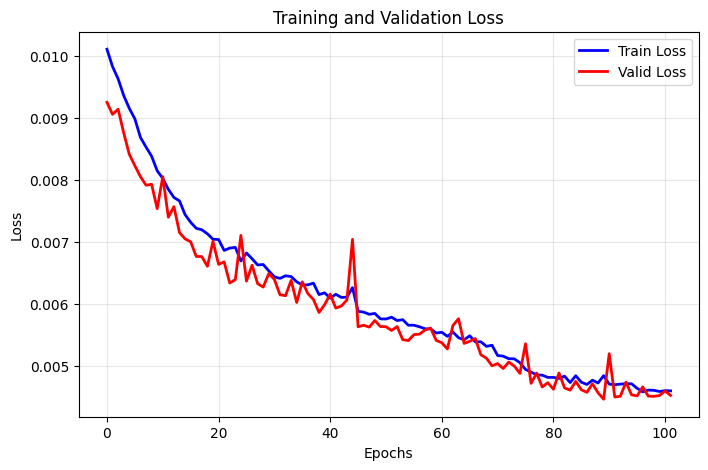

In [31]:
plot_history(history['train_loss'][10:], history['valid_loss'][10:])

#### Test pendulumenet

In [38]:
sample_idx = np.random.choice(config.TEST_SIZE)
sample_idx

1130

In [41]:
# Choose a sample from the test set
pendulum_net.eval()
with torch.no_grad():
    observations, questions, params = test_dataset[sample_idx]
    observations = observations.unsqueeze(0).to(device)  # Add batch dimension
    questions = questions.unsqueeze(0).to(device)

    possible_answer, mean, logvar = pendulum_net(observations, questions)
    possible_answer = possible_answer.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU
    observations = observations.squeeze().cpu().numpy()
    questions = questions.squeeze().cpu().numpy()
    L, b = params.numpy()

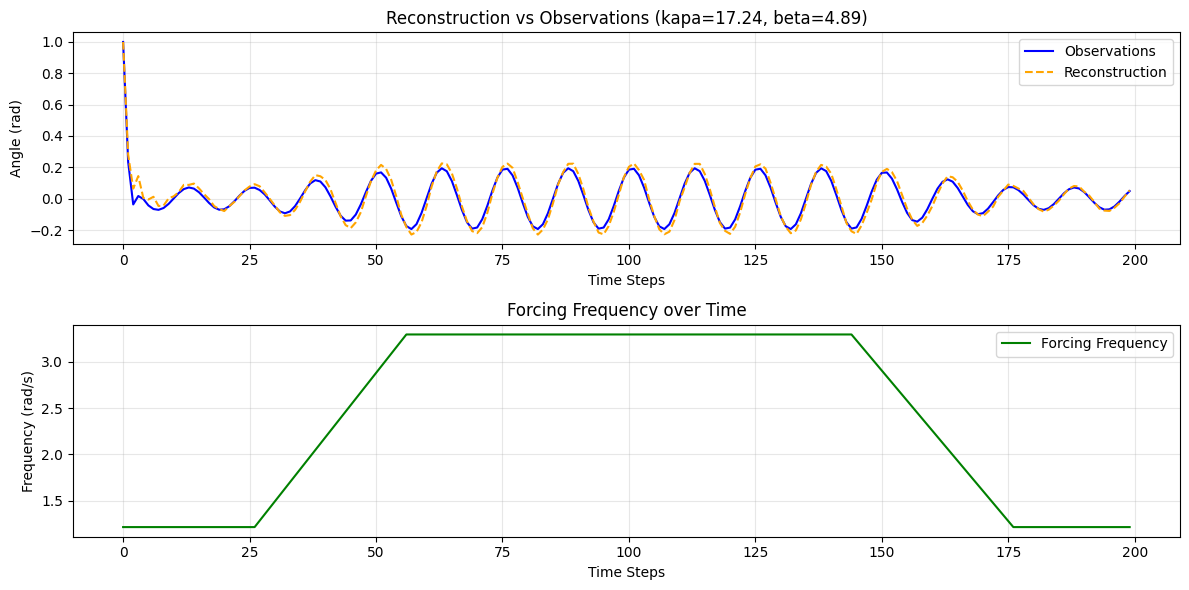

In [42]:
# Plot the results
# Fistly, plot the reconstruction and the observations
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(observations, label='Observations', color='blue')
plt.plot(possible_answer, label='Reconstruction', color='orange', linestyle='--')
plt.title(f'Reconstruction vs Observations (kapa={L:.2f}, beta={b:.2f})')
plt.xlabel('Time Steps')
plt.ylabel('Angle (rad)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.subplot(2, 1, 2)
plt.plot(questions, label='Forcing Frequency', color='green')
plt.title('Forcing Frequency over Time')
plt.xlabel('Time Steps')
plt.ylabel('Frequency (rad/s)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

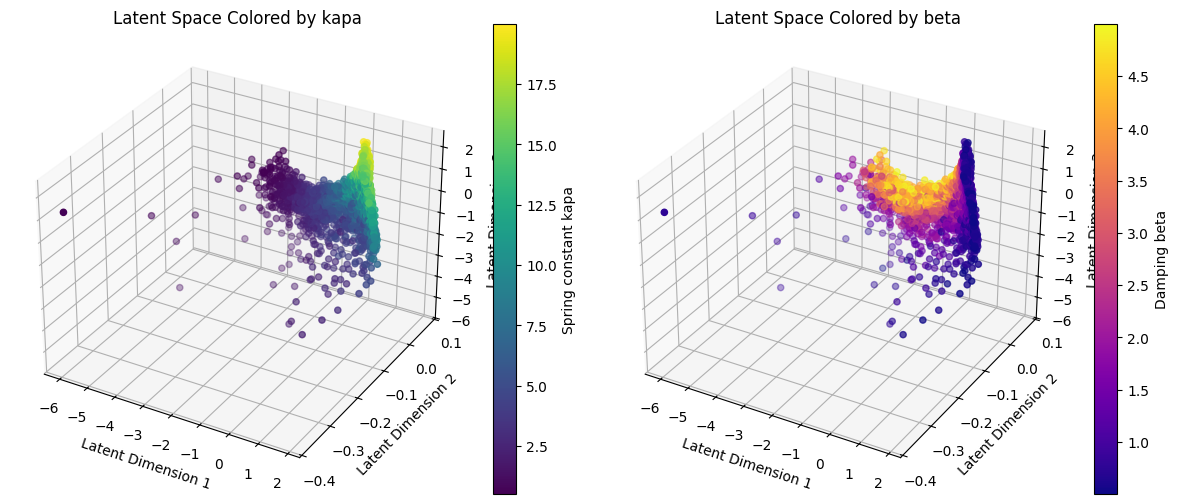

In [43]:
## Secondly, plot the latent space
all_means = []
all_params = []
pendulum_net.eval()
with torch.no_grad():
    for observations, questions, params in test_loader:
        observations = observations.to(device)
        questions = questions.to(device)
        mean, _ = pendulum_net.encoder(observations)
        all_means.append(mean.cpu().numpy())
        all_params.append(params.numpy())
all_means = np.concatenate(all_means, axis=0)
all_params = np.concatenate(all_params, axis=0)
L_values = all_params[:, 0]
b_values = all_params[:, 1]
latent_1 = all_means[:, 0]
latent_2 = all_means[:, 1]
latent_3 = all_means[:, 2]

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(131, projection='3d')
p = ax.scatter(latent_1, latent_2, latent_3, c=L_values, cmap='viridis')
fig.colorbar(p, ax=ax, label='Spring constant kapa')
ax.set_title('Latent Space Colored by kapa')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')

ax = fig.add_subplot(132, projection='3d')
p = ax.scatter(latent_1, latent_2, latent_3, c=b_values, cmap='plasma')
fig.colorbar(p, ax=ax, label='Damping beta')
ax.set_title('Latent Space Colored by beta')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')

plt.tight_layout()
plt.show()

In [ ]:
print(pendulum_net)